In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
train_mu0 = 0.
train_mu1 = 1.
train_rho01 = -0.6

train_sig0 = 1.0
train_sig1 = 1.5

train_cov00 = train_sig0 * train_sig0 
train_cov11 = train_sig1 * train_sig1
train_cov01 = train_rho01 * train_sig0 * train_sig1

train_cov = np.array( [[train_cov00, train_cov01], [train_cov01, train_cov11]] )
train_mu = np.array( [train_mu0, train_mu1])



true_mu0 = 0.2
true_mu1 = 0.8
true_rho01 = -0.6

true_sig0 = 0.9
true_sig1 = 1.3

true_cov00 = true_sig0 * true_sig0 
true_cov11 = true_sig1 * true_sig1
true_cov01 = true_rho01 * true_sig0 * true_sig1

true_cov = np.array( [[true_cov00, true_cov01], [true_cov01, true_cov11]] )
true_mu = np.array( [true_mu0, true_mu1])



#--- resolution is in same dimensions as features (not sigma/val)
res0 = 0.5
res1 = 0.8




## Plots to visualize these parameter choices

In [4]:

ngen_train = 100000
ngen_true = 10000

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, [res0, res1])

true_det_pts = np.random.normal( true_pts, [res0, res1])



<function matplotlib.pyplot.show(close=None, block=None)>

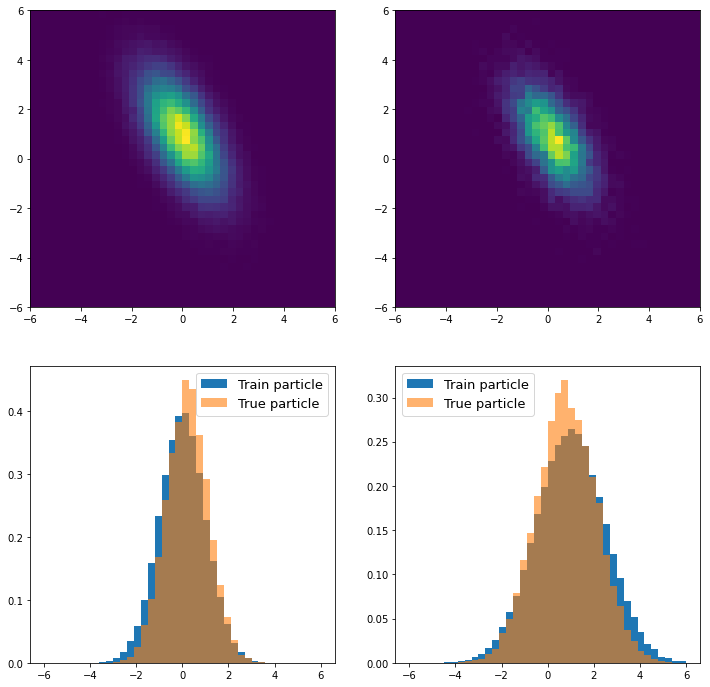

In [5]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='Train particle' )
ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='True particle', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

In [6]:
train_diff = train_det_pts - train_pts

In [7]:
diff_cov = np.cov( train_diff.T )

In [8]:
diff_cov

array([[0.2487226 , 0.00201261],
       [0.00201261, 0.64357569]])

In [9]:
np.sqrt(diff_cov[0,0])

0.498720961319625

In [10]:
np.sqrt(diff_cov[1,1])

0.8022316906657712

<function matplotlib.pyplot.show(close=None, block=None)>

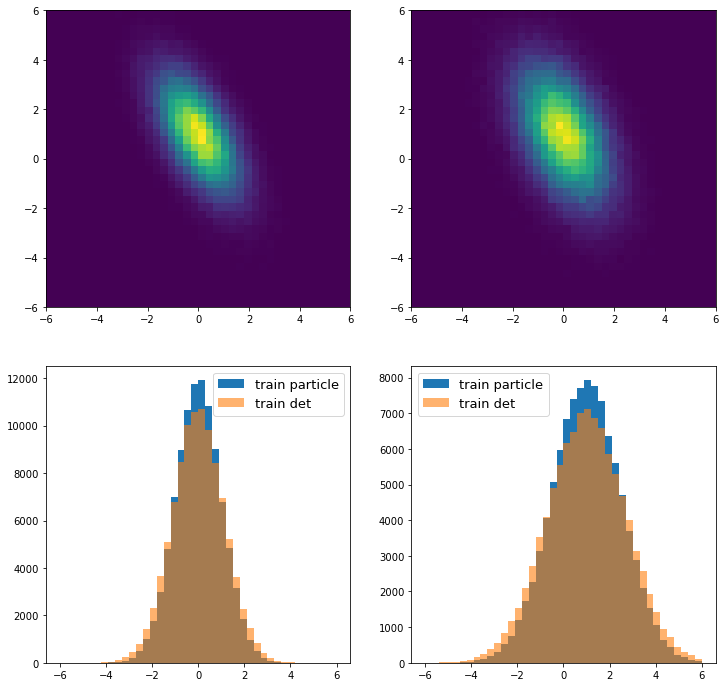

In [11]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

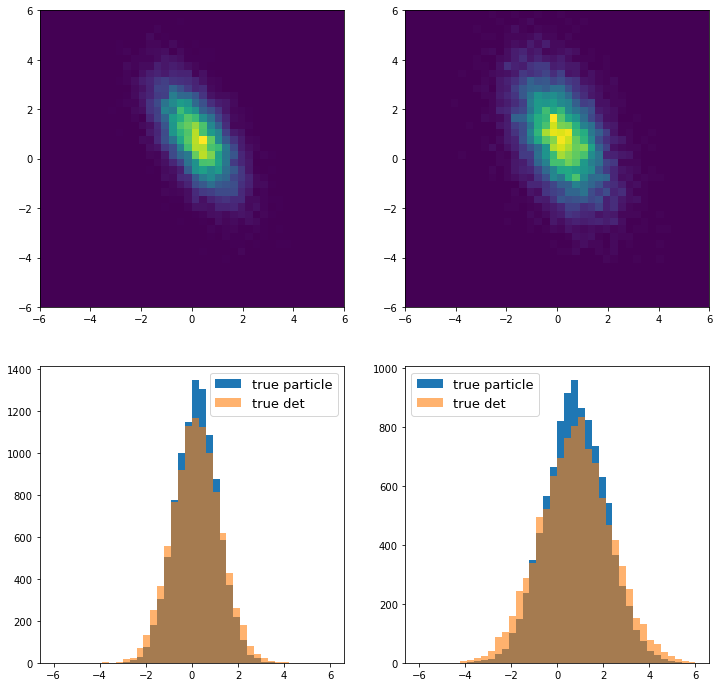

In [12]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)

ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

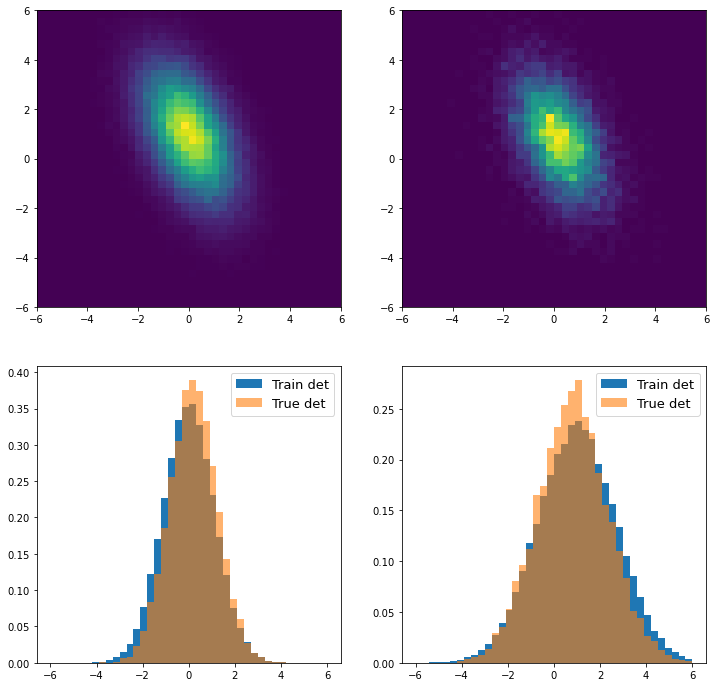

In [13]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)

ax[1][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

## Set up NN model for OmniFold

In [14]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-10-27 10:44:30.685750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-27 10:44:30.685982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-27 10:44:30.702521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-27 10:44:30.702964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-27 10:44:30.703138: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [15]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [16]:
%%time


verbose = True

of_niter = 4

of_weights = of.omnifold( train_both, true_det_pts, of_niter, model, verbose)




  shape of theta0_S : (100000, 2)
  shape of theta_unknown_S : (10000, 2)
  shape of xvals_1 :  (110000, 2)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 2)
  shape of xvals_2 :  (200000, 2)
  shape of yvals_2 :  (200000,)




ITERATION: 1

   -- ITERATION 1  STEP 1

Epoch 1/20


2023-10-27 10:44:32.755505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-27 10:44:32.757721: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3775f44bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-27 10:44:32.757733: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-27 10:44:32.757736: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-27 10:44:32.761065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-27 10:44:32.849433: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

9/9 [==============================] - 2s 17ms/step - loss: 0.6045 - accuracy: 0.4589 - val_loss: 0.5108 - val_accuracy: 0.4545
Epoch 2/20
9/9 [==============================] - 0s 5ms/step - loss: 0.4603 - accuracy: 0.4546 - val_loss: 0.3981 - val_accuracy: 0.4545
Epoch 3/20
9/9 [==============================] - 0s 5ms/step - loss: 0.3723 - accuracy: 0.4546 - val_loss: 0.3456 - val_accuracy: 0.4545
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 0.3409 - accuracy: 0.4546 - val_loss: 0.3365 - val_accuracy: 0.4545
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 0.3345 - accuracy: 0.4546 - val_loss: 0.3288 - val_accuracy: 0.4545
Epoch 6/20
9/9 [==============================] - 0s 5ms/step - loss: 0.3260 - accuracy: 0.4546 - val_loss: 0.3210 - val_accuracy: 0.4545
Epoch 7/20
9/9 [==============================] - 0s 4ms/step - loss: 0.3194 - accuracy: 0.4546 - val_loss: 0.3158 - val_accuracy: 0.4545
Epoch 8/20
9/9 [============================

9/9 [==============================] - 0s 5ms/step - loss: 0.1303 - accuracy: 0.4548 - val_loss: 0.1320 - val_accuracy: 0.4537
Epoch 19/20
9/9 [==============================] - 0s 5ms/step - loss: 0.1303 - accuracy: 0.4503 - val_loss: 0.1320 - val_accuracy: 0.4431
Epoch 20/20
10/10 [==============================] - 0s 606us/step

   -- ITERATION 2  STEP 2

Epoch 1/20
75/75 [==============================] - 1s 4ms/step - loss: 0.1986 - accuracy: 0.2500 - val_loss: 0.1627 - val_accuracy: 0.2501
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.2500 - val_loss: 0.1626 - val_accuracy: 0.2501
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.2500 - val_loss: 0.1626 - val_accuracy: 0.2501
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.2500 - val_loss: 0.1626 - val_accuracy: 0.2501
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1625 

75/75 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 15/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 16/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 17/20
75/75 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 18/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 19/20
75/75 [==============================] - 0s 3ms/step - loss: 0.1636 - accuracy: 0.2495 - val_loss: 0.1632 - val_accuracy: 0.2514
Epoch 20/20
10/10 [==============================] - 0s 696us/step

ITERATION: 4

   -- ITERATION 4  STEP 1

Epoch 1/20
9/9 [==============================] - 1s 18ms

In [17]:
of_weights

array([[[0.11424162, 0.10531639, 0.11092789, ..., 0.13363035,
         0.09064569, 0.11782184],
        [0.12032588, 0.10010104, 0.12818137, ..., 0.12947142,
         0.10025678, 0.09963068]],

       [[0.90445864, 0.91704077, 0.91746181, ..., 0.97456646,
         0.82585585, 0.95439553],
        [0.1143575 , 0.09106165, 0.12172879, ..., 0.12552927,
         0.08637606, 0.08877317]],

       [[1.04471803, 1.04094887, 1.04763436, ..., 1.07784033,
         0.96689373, 1.08265567],
        [0.11234094, 0.08250213, 0.11829364, ..., 0.12461292,
         0.0801382 , 0.08090886]],

       [[1.07014513, 1.18532014, 1.17453694, ..., 1.10417938,
         1.05810213, 1.17926991],
        [0.12462258, 0.08603258, 0.13079964, ..., 0.13709782,
         0.08384567, 0.08562738]]])

In [18]:
np.shape( of_weights)

(4, 2, 100000)

<function matplotlib.pyplot.show(close=None, block=None)>

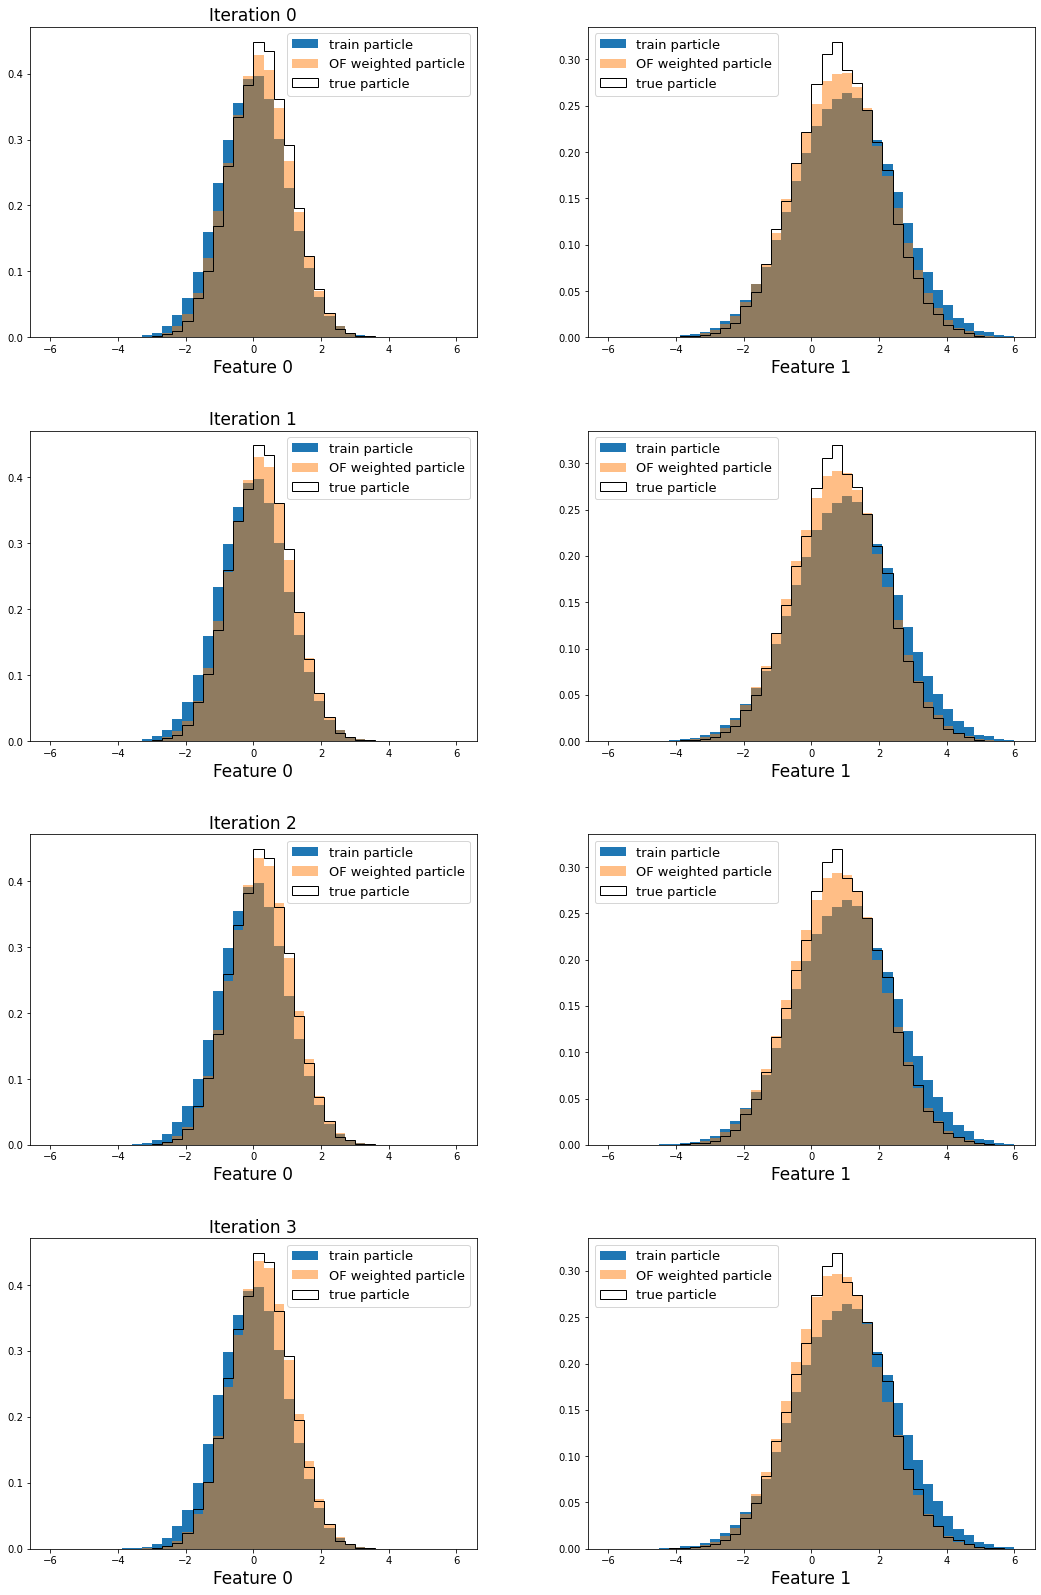

In [19]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)



for ofi in range(0,of_niter) :

    ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][0].hist( train_pts[:,0], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )

    ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='train particle' )
    ax[ofi][1].hist( train_pts[:,1], weights=of_weights[ofi,1,:], bins=hbins, range=[hmin,hmax], density=True, label='OF weighted particle', alpha=0.5 )
    ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], density=True, label='true particle', histtype='step', color='black' )


    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

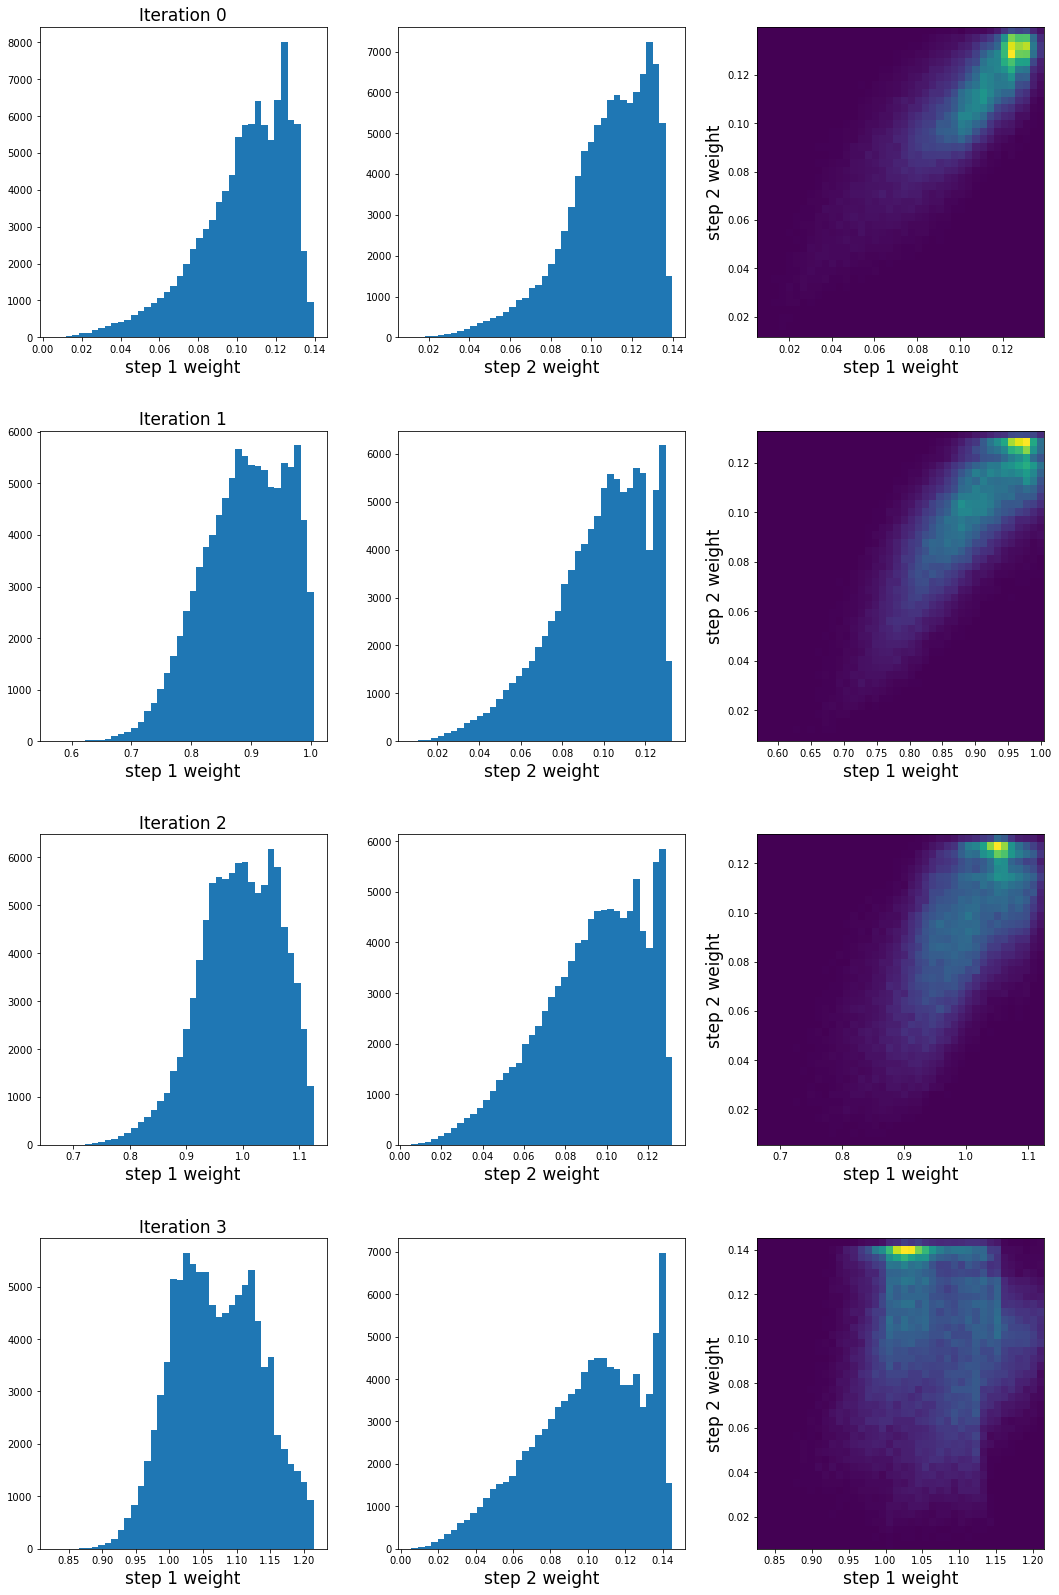

In [20]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

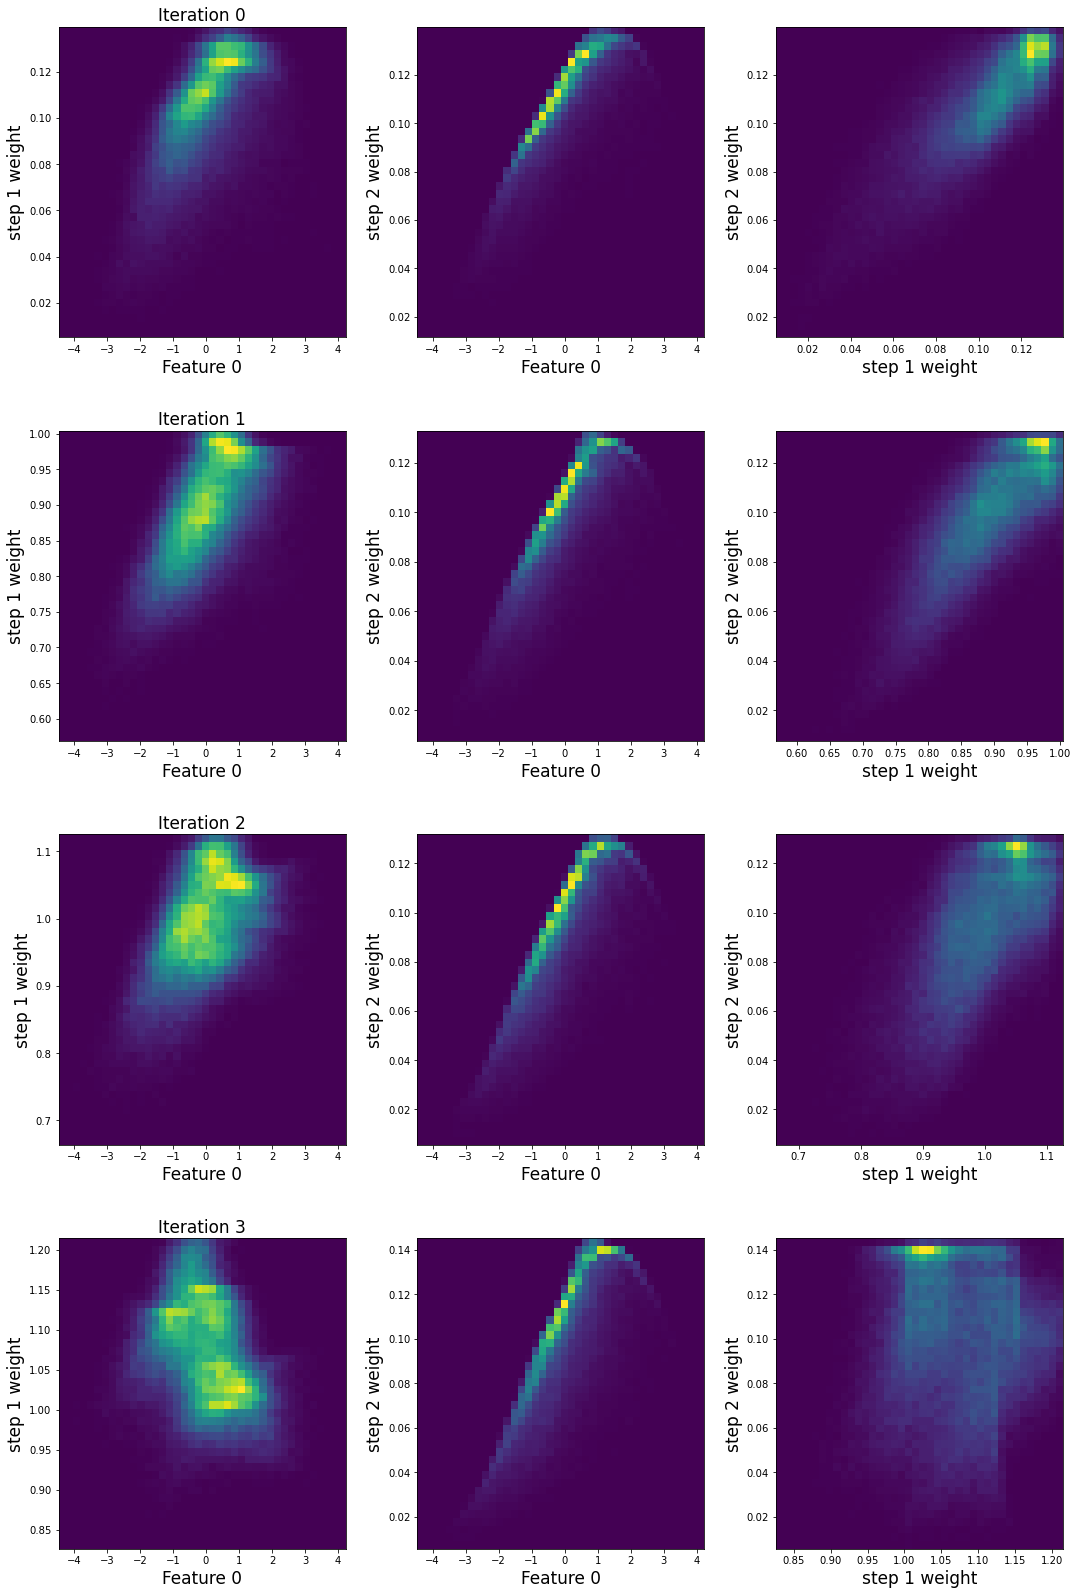

In [21]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,0], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,0], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

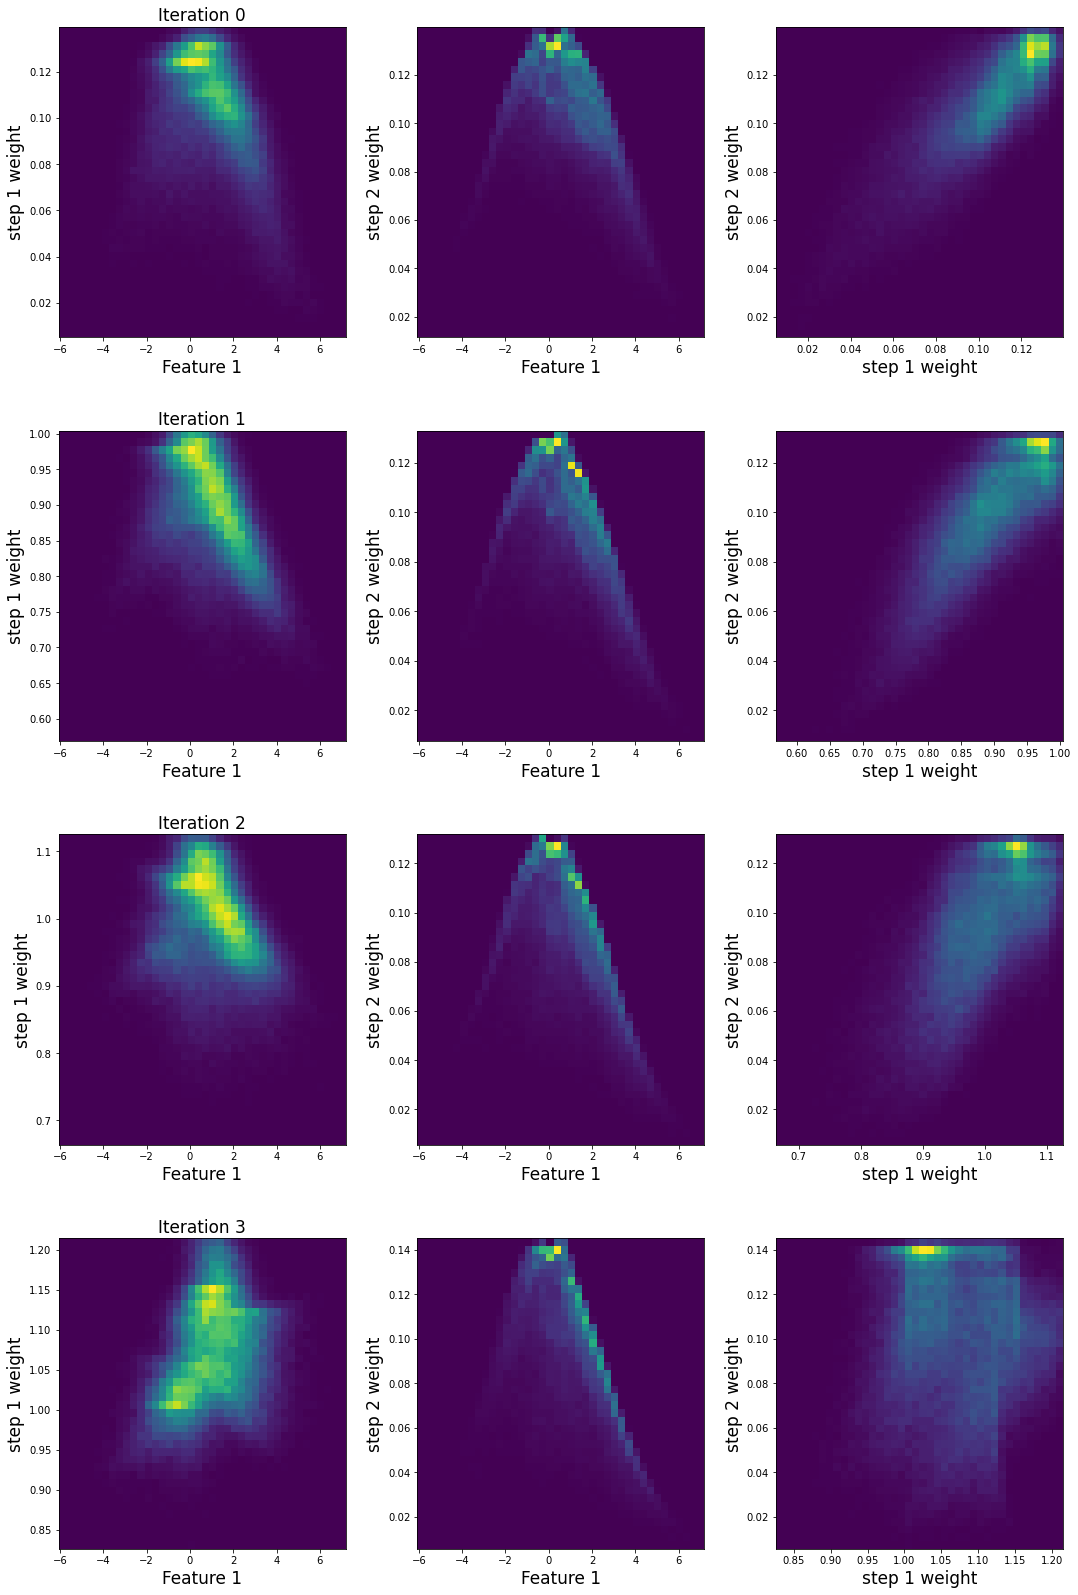

In [22]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,1], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,1], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [23]:
max_step2_weight = np.max( of_weights[3,1,:] )

<function matplotlib.pyplot.show(close=None, block=None)>

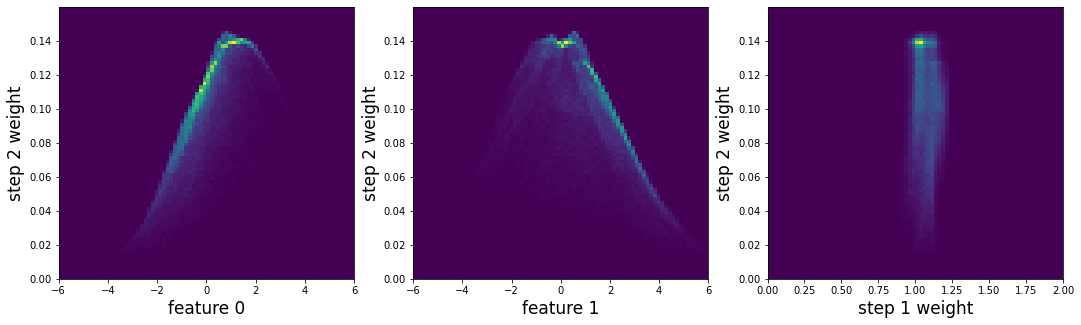

In [24]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))

hmin=-6
hmax=6
hbins=80

ax[0].hist2d( train_pts[:,0], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[1].hist2d( train_pts[:,1], of_weights[3,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[2].hist2d( of_weights[3,0,:], of_weights[3,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


lfontsize = 17

ax[0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


## Do the bootstrap samples in a loop

In [25]:
n_boot_samples = 80

do_bootstrap = True

verbose = False

bootstrap_weights = np.zeros( shape=(n_boot_samples, len(train_pts) ))

In [26]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = np.random.Generator.choice( true_det_pts, size=len(true_det_pts) )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, [res0, res1])
        
    boot_of_weights = of.omnifold( train_both, boot_true_det_pts, of_niter, model, verbose)
    
    bootstrap_weights[bi] = boot_of_weights[3,1,:]
    


 Creating bootstrap sample   0
10/10 [==============================] - 0s 709us/step

 Creating bootstrap sample   1
10/10 [==============================] - 0s 705us/step

 Creating bootstrap sample   2
10/10 [==============================] - 0s 739us/step

 Creating bootstrap sample   3
10/10 [==============================] - 0s 728us/step

 Creating bootstrap sample   4
10/10 [==============================] - 0s 634us/step

 Creating bootstrap sample   5
10/10 [==============================] - 0s 697us/step

 Creating bootstrap sample   6
10/10 [==============================] - 0s 744us/step

 Creating bootstrap sample   7
10/10 [==============================] - 0s 731us/step

 Creating bootstrap sample   8
10/10 [==============================] - 0s 700us/step

 Creating bootstrap sample   9
10/10 [==============================] - 0s 692us/step

 Creating bootstrap sample  10
10/10 [==============================] - 0s 685us/step

 Creating bootstrap sample  11
10/10 [====

10/10 [==============================] - 0s 716us/step

 Creating bootstrap sample  12
10/10 [==============================] - 0s 699us/step

 Creating bootstrap sample  13
10/10 [==============================] - 0s 719us/step

 Creating bootstrap sample  14
10/10 [==============================] - 0s 701us/step

 Creating bootstrap sample  15
10/10 [==============================] - 0s 657us/step

 Creating bootstrap sample  16
10/10 [==============================] - 0s 670us/step

 Creating bootstrap sample  17
10/10 [==============================] - 0s 734us/step

 Creating bootstrap sample  18
10/10 [==============================] - 0s 702us/step

 Creating bootstrap sample  19
10/10 [==============================] - 0s 685us/step

 Creating bootstrap sample  20
10/10 [==============================] - 0s 713us/step

 Creating bootstrap sample  21
10/10 [==============================] - 0s 728us/step

 Creating bootstrap sample  22
10/10 [==============================] - 0s

10/10 [==============================] - 0s 657us/step

 Creating bootstrap sample  24
10/10 [==============================] - 0s 696us/step

 Creating bootstrap sample  25
10/10 [==============================] - 0s 656us/step

 Creating bootstrap sample  26
10/10 [==============================] - 0s 713us/step

 Creating bootstrap sample  27
10/10 [==============================] - 0s 711us/step

 Creating bootstrap sample  28
10/10 [==============================] - 0s 644us/step

 Creating bootstrap sample  29
10/10 [==============================] - 0s 705us/step

 Creating bootstrap sample  30
10/10 [==============================] - 0s 713us/step

 Creating bootstrap sample  31
10/10 [==============================] - 0s 690us/step

 Creating bootstrap sample  32
10/10 [==============================] - 0s 663us/step

 Creating bootstrap sample  33
10/10 [==============================] - 0s 733us/step

 Creating bootstrap sample  34
10/10 [==============================] - 0s

10/10 [==============================] - 0s 742us/step

 Creating bootstrap sample  36
10/10 [==============================] - 0s 679us/step

 Creating bootstrap sample  37
10/10 [==============================] - 0s 659us/step

 Creating bootstrap sample  38
10/10 [==============================] - 0s 692us/step

 Creating bootstrap sample  39
10/10 [==============================] - 0s 666us/step

 Creating bootstrap sample  40
10/10 [==============================] - 0s 691us/step

 Creating bootstrap sample  41
10/10 [==============================] - 0s 710us/step

 Creating bootstrap sample  42
10/10 [==============================] - 0s 673us/step

 Creating bootstrap sample  43
10/10 [==============================] - 0s 751us/step

 Creating bootstrap sample  44
10/10 [==============================] - 0s 638us/step

 Creating bootstrap sample  45
10/10 [==============================] - 0s 749us/step

 Creating bootstrap sample  46
10/10 [==============================] - 0s

10/10 [==============================] - 0s 686us/step

 Creating bootstrap sample  48
10/10 [==============================] - 0s 692us/step

 Creating bootstrap sample  49
10/10 [==============================] - 0s 717us/step

 Creating bootstrap sample  50
10/10 [==============================] - 0s 724us/step

 Creating bootstrap sample  51
10/10 [==============================] - 0s 677us/step

 Creating bootstrap sample  52
10/10 [==============================] - 0s 738us/step

 Creating bootstrap sample  53
10/10 [==============================] - 0s 785us/step

 Creating bootstrap sample  54
10/10 [==============================] - 0s 744us/step

 Creating bootstrap sample  55
10/10 [==============================] - 0s 635us/step

 Creating bootstrap sample  56
10/10 [==============================] - 0s 745us/step

 Creating bootstrap sample  57
10/10 [==============================] - 0s 695us/step

 Creating bootstrap sample  58
10/10 [==============================] - 0s

10/10 [==============================] - 0s 725us/step

 Creating bootstrap sample  60
10/10 [==============================] - 0s 684us/step

 Creating bootstrap sample  61
10/10 [==============================] - 0s 659us/step

 Creating bootstrap sample  62
10/10 [==============================] - 0s 676us/step

 Creating bootstrap sample  63
10/10 [==============================] - 0s 734us/step

 Creating bootstrap sample  64
10/10 [==============================] - 0s 759us/step

 Creating bootstrap sample  65
10/10 [==============================] - 0s 742us/step

 Creating bootstrap sample  66
10/10 [==============================] - 0s 732us/step

 Creating bootstrap sample  67
10/10 [==============================] - 0s 722us/step

 Creating bootstrap sample  68
10/10 [==============================] - 0s 713us/step

 Creating bootstrap sample  69
10/10 [==============================] - 0s 679us/step

 Creating bootstrap sample  70
10/10 [==============================] - 0s

10/10 [==============================] - 0s 702us/step

 Creating bootstrap sample  72
10/10 [==============================] - 0s 645us/step

 Creating bootstrap sample  73
10/10 [==============================] - 0s 669us/step

 Creating bootstrap sample  74
10/10 [==============================] - 0s 672us/step

 Creating bootstrap sample  75
10/10 [==============================] - 0s 689us/step

 Creating bootstrap sample  76
10/10 [==============================] - 0s 703us/step

 Creating bootstrap sample  77
10/10 [==============================] - 0s 723us/step

 Creating bootstrap sample  78
10/10 [==============================] - 0s 696us/step

 Creating bootstrap sample  79
10/10 [==============================] - 0s 645us/step
CPU times: user 44min 11s, sys: 3min 56s, total: 48min 8s
Wall time: 35min 35s


In [27]:
bootstrap_weights

array([[0.13247231, 0.08639991, 0.13898715, ..., 0.13879769, 0.08087395,
        0.0790152 ],
       [0.12426968, 0.08955336, 0.12993053, ..., 0.14116877, 0.08338995,
        0.08686153],
       [0.13321391, 0.09118757, 0.13333564, ..., 0.14627579, 0.08913931,
        0.08717971],
       ...,
       [0.12998101, 0.08671696, 0.14403714, ..., 0.14258783, 0.07810406,
        0.07784241],
       [0.12213445, 0.09515577, 0.13456137, ..., 0.12551177, 0.08964425,
        0.08778937],
       [0.12503999, 0.08362254, 0.13675007, ..., 0.12392125, 0.08334052,
        0.0724555 ]])

In [28]:
of_weights[3,1,:]

array([0.12462258, 0.08603258, 0.13079964, ..., 0.13709782, 0.08384567,
       0.08562738])

In [29]:
bootstrap_weights[0]

array([0.13247231, 0.08639991, 0.13898715, ..., 0.13879769, 0.08087395,
       0.0790152 ])

In [30]:
np.cov( bootstrap_weights[:,0])

array(3.62504954e-05)

In [31]:
bootstrap_weights[:,100]

array([0.12911779, 0.12545814, 0.12583436, 0.12602217, 0.13475788,
       0.13708647, 0.13587669, 0.13308927, 0.12946633, 0.12467739,
       0.12306727, 0.12857342, 0.1274133 , 0.12454963, 0.13796069,
       0.14186497, 0.13334426, 0.12670878, 0.13495882, 0.1389538 ,
       0.12859109, 0.1404434 , 0.13526826, 0.12623362, 0.12755546,
       0.13146415, 0.13859518, 0.14378282, 0.15114248, 0.13121   ,
       0.13134642, 0.13342968, 0.13394859, 0.12809283, 0.12629978,
       0.14175677, 0.14358649, 0.14330564, 0.13881437, 0.13025701,
       0.13095556, 0.13072443, 0.14619493, 0.13911156, 0.13522582,
       0.13073386, 0.14445576, 0.14054547, 0.12327082, 0.14338264,
       0.13959453, 0.13513663, 0.13323948, 0.12233187, 0.13539955,
       0.13097371, 0.12047604, 0.14193922, 0.14536805, 0.13996562,
       0.13528128, 0.12760967, 0.11611835, 0.13009033, 0.12717886,
       0.13335894, 0.13729173, 0.12324825, 0.13553916, 0.14151439,
       0.13635227, 0.12837851, 0.13024886, 0.13301717, 0.12935

<function matplotlib.pyplot.show(close=None, block=None)>

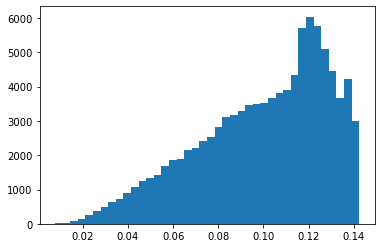

In [32]:
plt.hist( bootstrap_weights[1,:], bins=40)
plt.show

In [33]:
np.mean( bootstrap_weights, axis=0 )

array([0.12381586, 0.08683878, 0.13773779, ..., 0.13859489, 0.08378021,
       0.07946309])

In [34]:
bootstrap_w2 = bootstrap_weights * bootstrap_weights

In [35]:
bootstrap_w2

array([[0.01754891, 0.00746494, 0.01931743, ..., 0.0192648 , 0.0065406 ,
        0.0062434 ],
       [0.01544295, 0.0080198 , 0.01688194, ..., 0.01992862, 0.00695388,
        0.00754493],
       [0.01774595, 0.00831517, 0.01777839, ..., 0.02139661, 0.00794582,
        0.0076003 ],
       ...,
       [0.01689506, 0.00751983, 0.0207467 , ..., 0.02033129, 0.00610024,
        0.00605944],
       [0.01491682, 0.00905462, 0.01810676, ..., 0.0157532 , 0.00803609,
        0.00770697],
       [0.015635  , 0.00699273, 0.01870058, ..., 0.01535648, 0.00694564,
        0.0052498 ]])

In [36]:
bootstrap_variance = np.mean( bootstrap_w2, axis=0 ) - np.mean( bootstrap_weights, axis=0 ) * np.mean( bootstrap_weights, axis=0 )

In [37]:
bootstrap_variance

array([3.57973642e-05, 1.96674781e-05, 2.75259252e-05, ...,
       3.51225371e-05, 1.85961854e-05, 2.88804955e-05])

In [38]:
bootstrap_rms = np.sqrt( bootstrap_variance )

In [39]:
bootstrap_rms

array([0.00598309, 0.0044348 , 0.00524652, ..., 0.00592643, 0.00431233,
       0.00537406])

In [40]:
col_vec = np.array([[11],[22],[33]])

In [41]:
col_vec

array([[11],
       [22],
       [33]])

In [42]:
row_vec = col_vec.T

In [43]:
row_vec

array([[11, 22, 33]])

In [44]:
col_times_row = col_vec * row_vec

In [45]:
col_times_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [46]:
col_vec.shape

(3, 1)

In [47]:
row_vec.shape

(1, 3)

In [48]:
col_times_row.shape

(3, 3)

In [49]:
row_times_col = row_vec * col_vec

In [50]:
row_times_col

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [51]:
row_times_row = row_vec * row_vec

In [52]:
row_times_row

array([[ 121,  484, 1089]])

In [53]:
#row_dot_row = np.dot(row_vec,row_vec)

In [54]:
row_dot_col = np.dot(row_vec,col_vec)

In [55]:
row_dot_col

array([[1694]])

In [56]:
row_dot_col.shape

(1, 1)

In [57]:
col_dot_row = np.dot(col_vec,row_vec)

In [58]:
col_dot_row

array([[ 121,  242,  363],
       [ 242,  484,  726],
       [ 363,  726, 1089]])

In [59]:
bootstrap_weights.shape

(80, 100000)

In [60]:
bootstrap_weights.T

array([[0.13247231, 0.12426968, 0.13321391, ..., 0.12998101, 0.12213445,
        0.12503999],
       [0.08639991, 0.08955336, 0.09118757, ..., 0.08671696, 0.09515577,
        0.08362254],
       [0.13898715, 0.12993053, 0.13333564, ..., 0.14403714, 0.13456137,
        0.13675007],
       ...,
       [0.13879769, 0.14116877, 0.14627579, ..., 0.14258783, 0.12551177,
        0.12392125],
       [0.08087395, 0.08338995, 0.08913931, ..., 0.07810406, 0.08964425,
        0.08334052],
       [0.0790152 , 0.08686153, 0.08717971, ..., 0.07784241, 0.08778937,
        0.0724555 ]])

In [61]:
bootstrap_weights.T.shape

(100000, 80)

In [62]:
bootstrap_weights_dot = np.dot( bootstrap_weights, bootstrap_weights.T )

In [63]:
bootstrap_weights_dot

array([[1067.09166843, 1071.34245712, 1106.00444891, ..., 1092.0798544 ,
        1074.08635602, 1058.4967495 ],
       [1071.34245712, 1077.96935575, 1112.74224955, ..., 1098.22085561,
        1082.14106012, 1064.63985864],
       [1106.00444891, 1112.74224955, 1151.44003983, ..., 1134.70135327,
        1118.13375332, 1100.16841083],
       ...,
       [1092.0798544 , 1098.22085561, 1134.70135327, ..., 1124.00843285,
        1104.21287878, 1086.76795076],
       [1074.08635602, 1082.14106012, 1118.13375332, ..., 1104.21287878,
        1092.73440391, 1072.22206814],
       [1058.4967495 , 1064.63985864, 1100.16841083, ..., 1086.76795076,
        1072.22206814, 1057.57088097]])

In [64]:
bootstrap_weights_dot.shape

(80, 80)

In [65]:
#bootstrap_weights_dot2 = np.dot( bootstrap_weights.T, bootstrap_weights )

In [66]:
#bootstrap_weights_dot2

In [67]:
bootstrap_weights[:,0]

array([0.13247231, 0.12426968, 0.13321391, 0.12781706, 0.12351473,
       0.13062648, 0.12253537, 0.1266923 , 0.12482434, 0.11855256,
       0.12405068, 0.11288357, 0.12424067, 0.12278402, 0.12849399,
       0.12661774, 0.13104828, 0.12803185, 0.1118715 , 0.10950419,
       0.12478186, 0.13340129, 0.1155692 , 0.11556774, 0.13094541,
       0.12366161, 0.12372386, 0.11978458, 0.11545513, 0.11853323,
       0.12445821, 0.11769042, 0.12131674, 0.12385172, 0.10950995,
       0.1300471 , 0.13144708, 0.12825012, 0.12191087, 0.12993531,
       0.11986737, 0.12167408, 0.13055643, 0.12153096, 0.12130584,
       0.11819439, 0.12055115, 0.12314938, 0.12535572, 0.11688729,
       0.12742874, 0.12399083, 0.12242248, 0.12027881, 0.11797708,
       0.13085234, 0.11563129, 0.1174449 , 0.12850612, 0.11131986,
       0.11403668, 0.11967916, 0.13021797, 0.12614806, 0.1308506 ,
       0.12552638, 0.13113765, 0.12477379, 0.13197504, 0.11775675,
       0.13073584, 0.13496312, 0.13005888, 0.12359754, 0.12954

In [68]:
bootstrap_weights[:,1]

array([0.08639991, 0.08955336, 0.09118757, 0.09041947, 0.08219864,
       0.08459171, 0.08193965, 0.08366936, 0.0883038 , 0.09244302,
       0.09290258, 0.08567068, 0.08715542, 0.08349773, 0.09322944,
       0.086689  , 0.08015575, 0.08892978, 0.09148593, 0.08158516,
       0.0928528 , 0.08901782, 0.08456397, 0.08896799, 0.08895847,
       0.08449724, 0.08942937, 0.08415893, 0.08582771, 0.08322222,
       0.08391906, 0.08522134, 0.0888513 , 0.09501541, 0.08419339,
       0.08885456, 0.08367398, 0.08471581, 0.08378024, 0.09219813,
       0.08960805, 0.08705391, 0.09732877, 0.08648983, 0.08491441,
       0.09411128, 0.07969832, 0.0811718 , 0.09079526, 0.09226362,
       0.08228909, 0.08857876, 0.09291268, 0.0865493 , 0.08682209,
       0.09418229, 0.0862002 , 0.09441347, 0.09051216, 0.08883568,
       0.08516563, 0.08215219, 0.08190665, 0.08763826, 0.09522505,
       0.08436984, 0.08177537, 0.08234268, 0.08486223, 0.08555815,
       0.07791945, 0.0846383 , 0.08537746, 0.08450831, 0.08340

In [69]:
combined = np.column_stack( (bootstrap_weights[:,0], bootstrap_weights[:,1]))

In [70]:
combined

array([[0.13247231, 0.08639991],
       [0.12426968, 0.08955336],
       [0.13321391, 0.09118757],
       [0.12781706, 0.09041947],
       [0.12351473, 0.08219864],
       [0.13062648, 0.08459171],
       [0.12253537, 0.08193965],
       [0.1266923 , 0.08366936],
       [0.12482434, 0.0883038 ],
       [0.11855256, 0.09244302],
       [0.12405068, 0.09290258],
       [0.11288357, 0.08567068],
       [0.12424067, 0.08715542],
       [0.12278402, 0.08349773],
       [0.12849399, 0.09322944],
       [0.12661774, 0.086689  ],
       [0.13104828, 0.08015575],
       [0.12803185, 0.08892978],
       [0.1118715 , 0.09148593],
       [0.10950419, 0.08158516],
       [0.12478186, 0.0928528 ],
       [0.13340129, 0.08901782],
       [0.1155692 , 0.08456397],
       [0.11556774, 0.08896799],
       [0.13094541, 0.08895847],
       [0.12366161, 0.08449724],
       [0.12372386, 0.08942937],
       [0.11978458, 0.08415893],
       [0.11545513, 0.08582771],
       [0.11853323, 0.08322222],
       [0.

In [71]:
pair_cov = np.cov( combined )

In [72]:
pair_cov

array([[0.00106133, 0.00079973, 0.00096813, ..., 0.00099664, 0.00062149,
        0.0009541 ],
       [0.00079973, 0.00060261, 0.0007295 , ..., 0.00075098, 0.0004683 ,
        0.00071893],
       [0.00096813, 0.0007295 , 0.00088311, ..., 0.00090911, 0.00056691,
        0.00087031],
       ...,
       [0.00099664, 0.00075098, 0.00090911, ..., 0.00093589, 0.0005836 ,
        0.00089594],
       [0.00062149, 0.0004683 , 0.00056691, ..., 0.0005836 , 0.00036392,
        0.00055869],
       [0.0009541 , 0.00071893, 0.00087031, ..., 0.00089594, 0.00055869,
        0.0008577 ]])

In [73]:
combined_row = np.row_stack( (bootstrap_weights[:,0], bootstrap_weights[:,2]))

In [74]:
combined_row

array([[0.13247231, 0.12426968, 0.13321391, 0.12781706, 0.12351473,
        0.13062648, 0.12253537, 0.1266923 , 0.12482434, 0.11855256,
        0.12405068, 0.11288357, 0.12424067, 0.12278402, 0.12849399,
        0.12661774, 0.13104828, 0.12803185, 0.1118715 , 0.10950419,
        0.12478186, 0.13340129, 0.1155692 , 0.11556774, 0.13094541,
        0.12366161, 0.12372386, 0.11978458, 0.11545513, 0.11853323,
        0.12445821, 0.11769042, 0.12131674, 0.12385172, 0.10950995,
        0.1300471 , 0.13144708, 0.12825012, 0.12191087, 0.12993531,
        0.11986737, 0.12167408, 0.13055643, 0.12153096, 0.12130584,
        0.11819439, 0.12055115, 0.12314938, 0.12535572, 0.11688729,
        0.12742874, 0.12399083, 0.12242248, 0.12027881, 0.11797708,
        0.13085234, 0.11563129, 0.1174449 , 0.12850612, 0.11131986,
        0.11403668, 0.11967916, 0.13021797, 0.12614806, 0.1308506 ,
        0.12552638, 0.13113765, 0.12477379, 0.13197504, 0.11775675,
        0.13073584, 0.13496312, 0.13005888, 0.12

In [75]:
pair_cov_rs = np.cov( combined_row )

In [76]:
pair_cov_rs

array([[3.62504954e-05, 1.07675779e-05],
       [1.07675779e-05, 2.78743547e-05]])

In [77]:
pair_cor = np.corrcoef(combined_row)

In [78]:
pair_cor

array([[1.        , 0.33873388],
       [0.33873388, 1.        ]])

In [79]:
pair_cor[0,1]

0.3387338801767052

In [330]:
ncalc = 100000
corr_array = np.zeros( ncalc )

point_index = 53

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
    corr_array[i] = pair_cor[0,1]


In [331]:
corr_array

array([-0.01723241, -0.165116  ,  0.41010126, ...,  0.07198338,
        0.02624528, -0.14003612])

<function matplotlib.pyplot.show(close=None, block=None)>

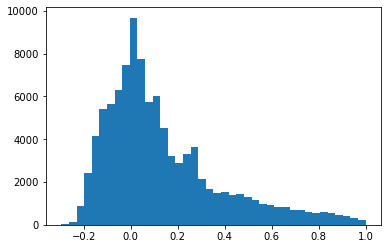

In [332]:
plt.hist( corr_array, bins=40)
plt.show

In [333]:
train_pts[point_index]

array([0.70199258, 1.42800043])

In [334]:
df0 = train_pts[:,0] - train_pts[point_index,0]
df1 = train_pts[:,1] - train_pts[point_index,1]
dr = np.sqrt( df0*df0 + df1*df1)

<function matplotlib.pyplot.show(close=None, block=None)>

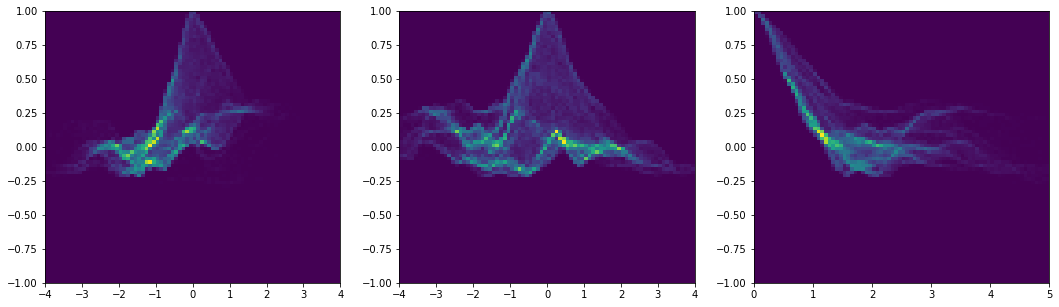

In [335]:
fig,ax = plt.subplots( 1, 3, figsize=(18,5))
ax[0].hist2d( df0, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[1].hist2d( df1, corr_array, bins=[80,80], range=([-4,4],[-1,1]))
ax[2].hist2d( dr, corr_array, bins=[80,80], range=([0,5],[-1,1]))
plt.show